In [ ]:
# Uncomment line below to install exlib
# !pip install exlib

In [1]:
import sys
import exlib
import torch
from datasets import load_dataset
from exlib.datasets.mass_maps import MassMapsConvnetForImageRegression

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Load model
model = MassMapsConvnetForImageRegression.from_pretrained('BrachioLab/massmaps-conv')
model = model.to(device)

TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()


In [3]:
# Load data
train_dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k', split='train')
val_dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k', split='validation')
test_dataset = load_dataset('BrachioLab/massmaps-cosmogrid-100k', split='test')
train_dataset.set_format('torch', columns=['input', 'label'])
val_dataset.set_format('torch', columns=['input', 'label'])
test_dataset.set_format('torch', columns=['input', 'label'])

In [4]:
# Baselines
from exlib.features.vision.mass_maps import MassMapsOracle, MassMapsOne
from exlib.features.vision.watershed import WatershedGroups
from exlib.features.vision.quickshift import QuickshiftGroups
from exlib.features.vision.patch import PatchGroups

In [5]:
watershed_baseline = WatershedGroups(min_dist=10, compactness=0).to(device)

In [6]:
# Alignment
from exlib.datasets.mass_maps import MassMapsAlignment
massmaps_align = MassMapsAlignment().to(device)

In [7]:
# Eval
batch_size = 5
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

import torch.nn.functional as F
from tqdm.auto import tqdm

model.eval()
mse_loss_all = 0
total = 0
alignment_scores_all = []

with torch.no_grad():
    for bi, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        X = batch['input'].to(device)
        y = batch['label'].to(device)
        out = model(X)
        # loss
        loss = F.mse_loss(out, y, reduction='none')
        mse_loss_all = mse_loss_all + loss.sum(0)
        total += X.shape[0]

        # baseline
        groups = watershed_baseline(X)

        # alignment
        alignment_scores = massmaps_align(groups, X)
        alignment_scores_all.extend(alignment_scores.flatten(1).cpu().numpy().tolist())
        
        if bi > 10:
            break
            
loss_avg = mse_loss_all / total

print(f'Omega_m loss {loss_avg[0].item():.4f}, sigma_8 loss {loss_avg[1].item():.4f}, avg loss {loss_avg.mean().item():.4f}')

  0%|          | 0/2000 [00:00<?, ?it/s]

Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)


Omega_m loss 0.0058, sigma_8 loss 0.0095, avg loss 0.0076


In [8]:
total_score = torch.mean(torch.stack([torch.mean(torch.tensor(alignment_scores_all[i])) \
                      for i in range(len(alignment_scores_all))]))
total_score

tensor(0.5629)

# Show alignment scores examples

In [9]:
import math
import matplotlib.pyplot as plt
from exlib.datasets.mass_maps import MassMapsAlignment

def show_example(groups, X, img_idx=0):
    massmaps_align = MassMapsAlignment().to(device)
    alignment_results = massmaps_align(groups, X, reduce='none')
    
    m = groups.shape[1]
    cols = 8
    rows = math.ceil(m / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*4))
    axs = axs.ravel()

    image = X[img_idx]
    for idx in range(len(axs)):
        if idx < m:
            mask = groups[img_idx][idx]

            if mask.sum() > 0:
                axs[idx].imshow(image[0].cpu().numpy())
                axs[idx].contour(mask.cpu().numpy() > 0, 2, colors='red')
                axs[idx].contourf(mask.cpu().numpy() > 0, 2, hatches=['//', None, None],
                                cmap='gray', extend='neither', linestyles='--', alpha=0.01)
                p_void_ = alignment_results['p_void_']
                p_cluster_ = alignment_results['p_cluster_']
                purity = alignment_results['purity']
                # total_score = alignment_scores_void[0][idx].item() * massmaps_align.void_scale + alignment_scores_cluster[0][idx].item() * massmaps_align.cluster_scale
                axs[idx].set_title(f'void {p_void_[0][idx].item():.5f}\ncluster {p_cluster_[0][idx].item():.5f}\npurity {purity[0][idx].item():.5f}')
        axs[idx].axis('off')
    plt.show()

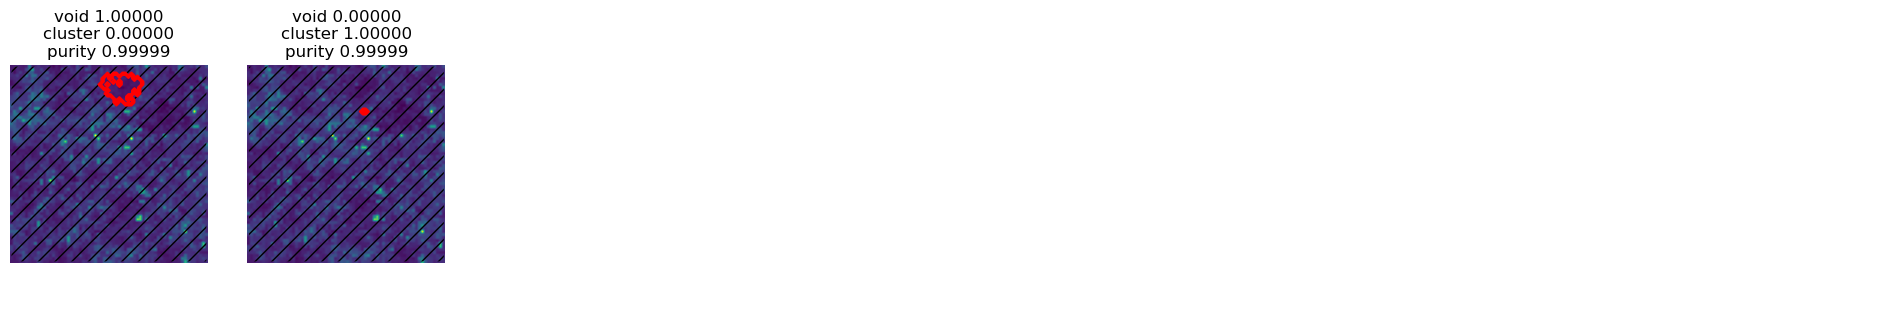

In [10]:
import torch
from exlib.datasets.mass_maps import MassMapsAlignment
watershed_baseline = WatershedGroups(min_dist=10, compactness=0).to(device).to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = watershed_baseline(X)
groups_show = torch.stack([groups[0:1,2], groups[0:1,6]], dim=1)
show_example(groups_show, X[0:1])

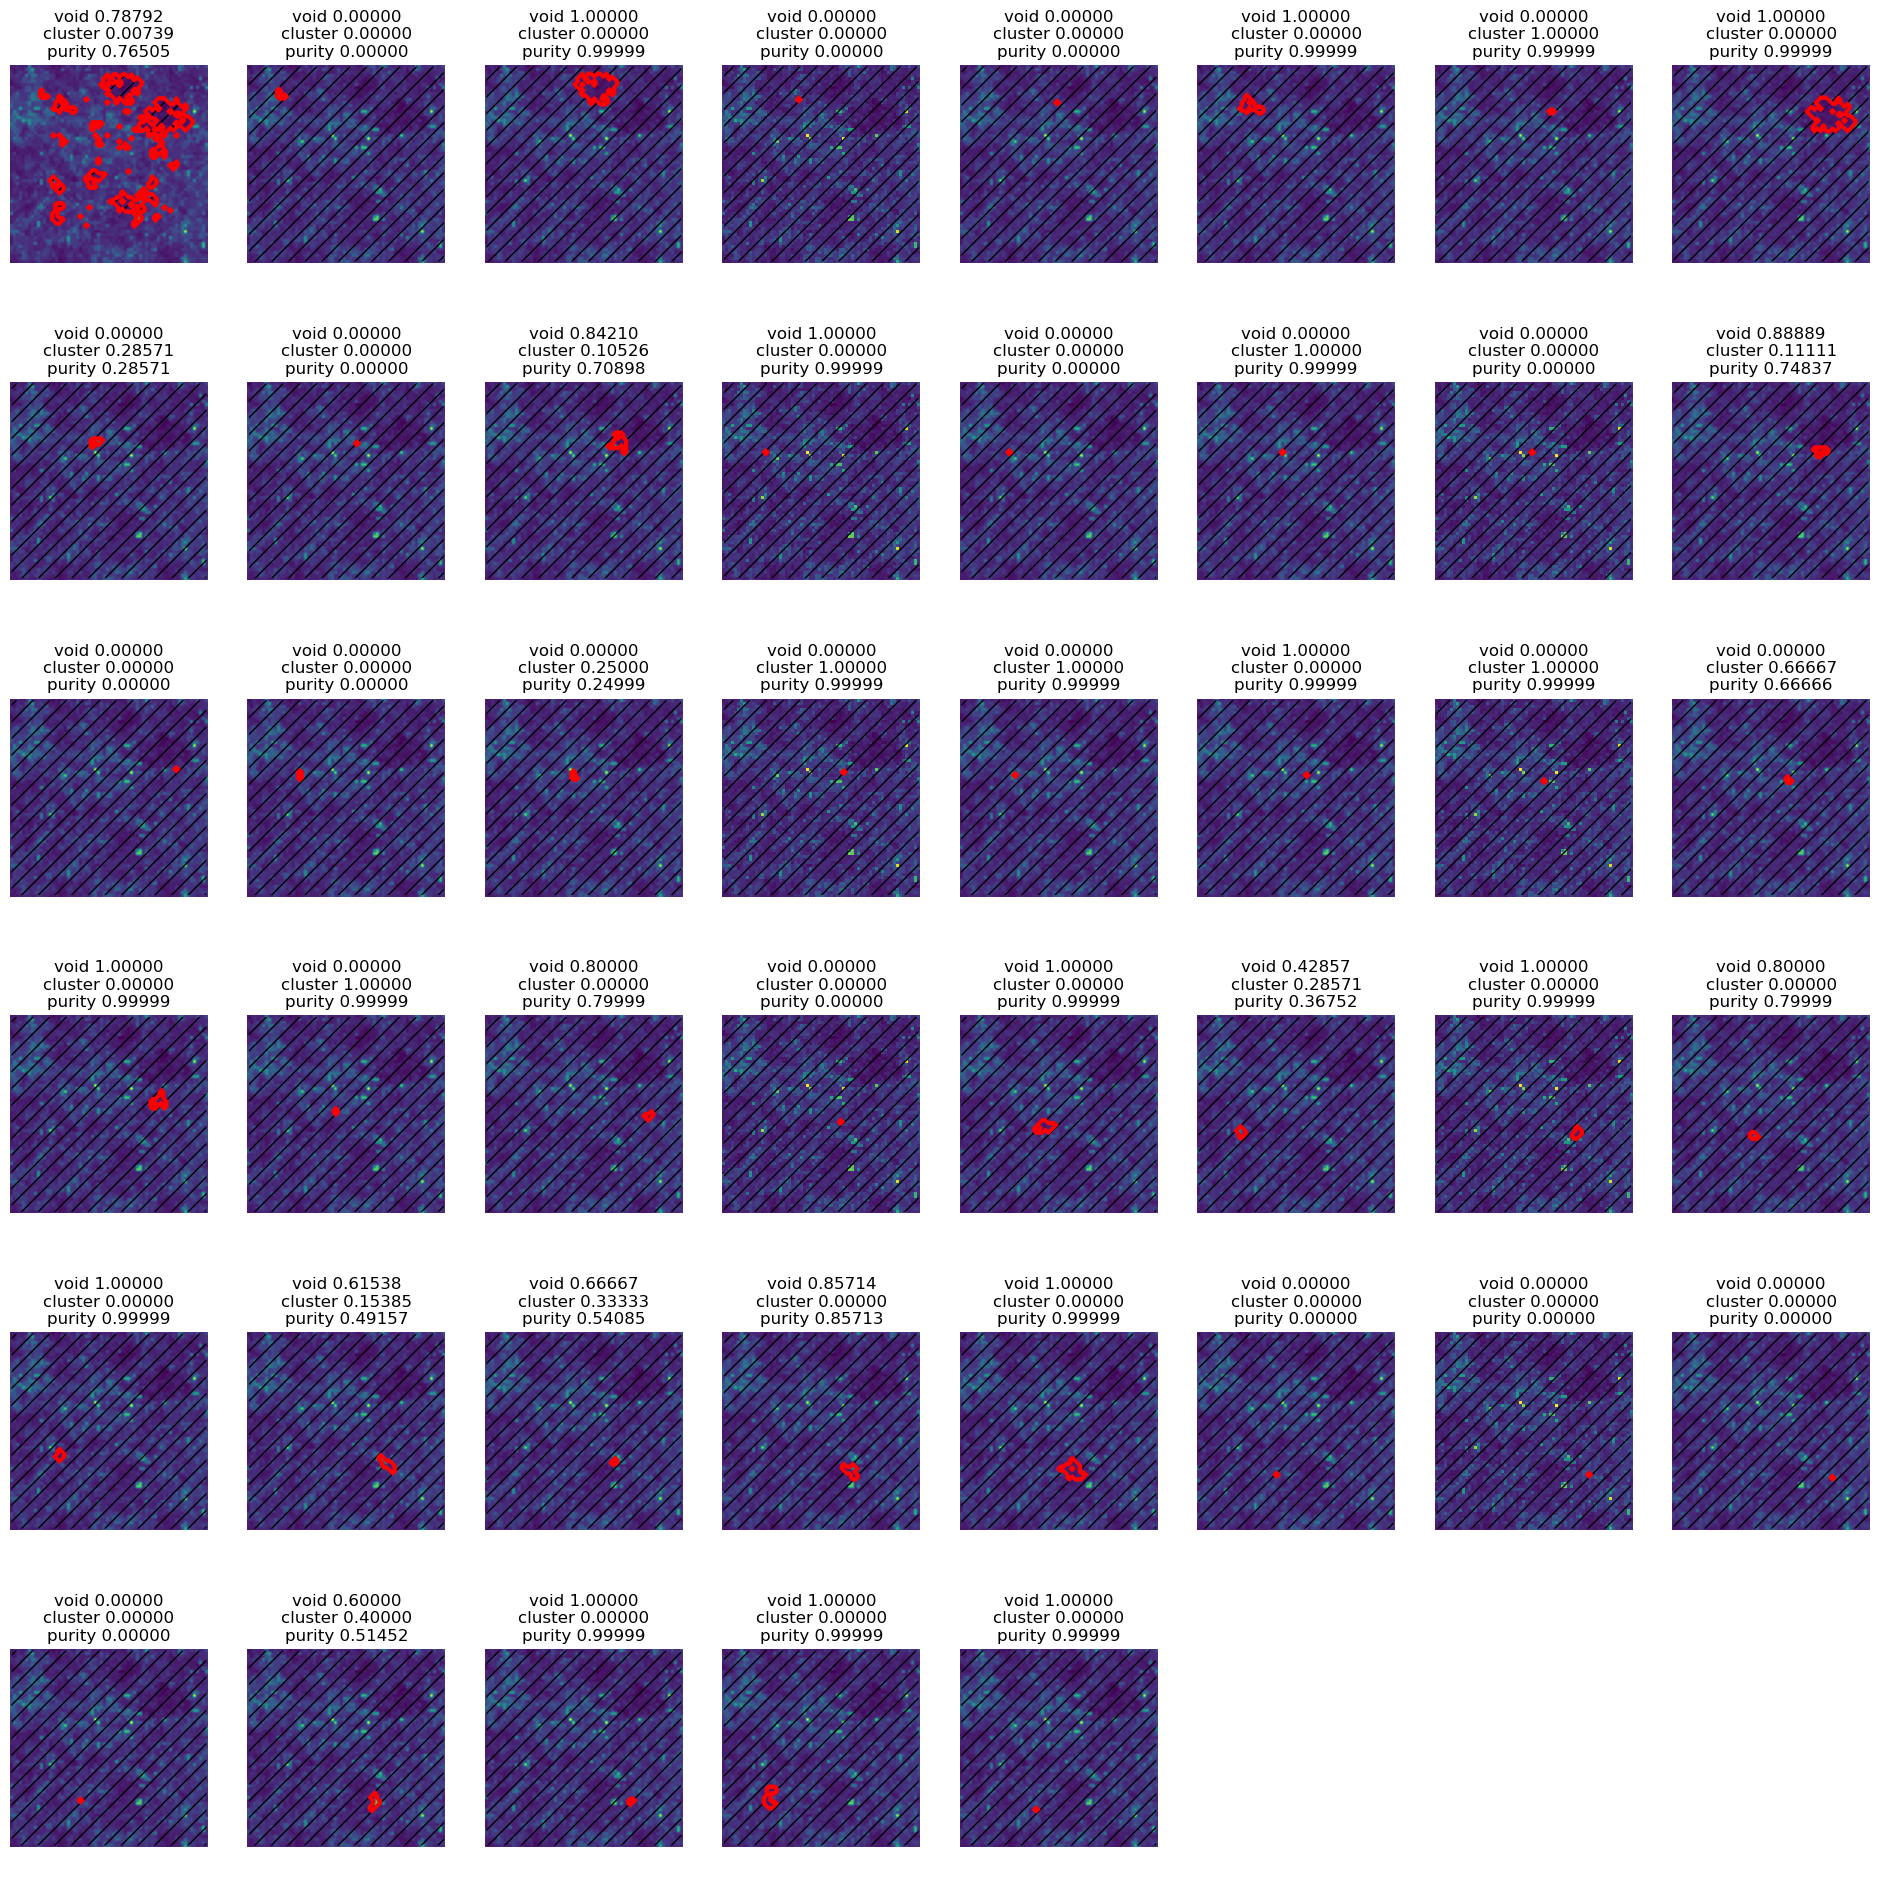

In [15]:
show_example(groups, X)

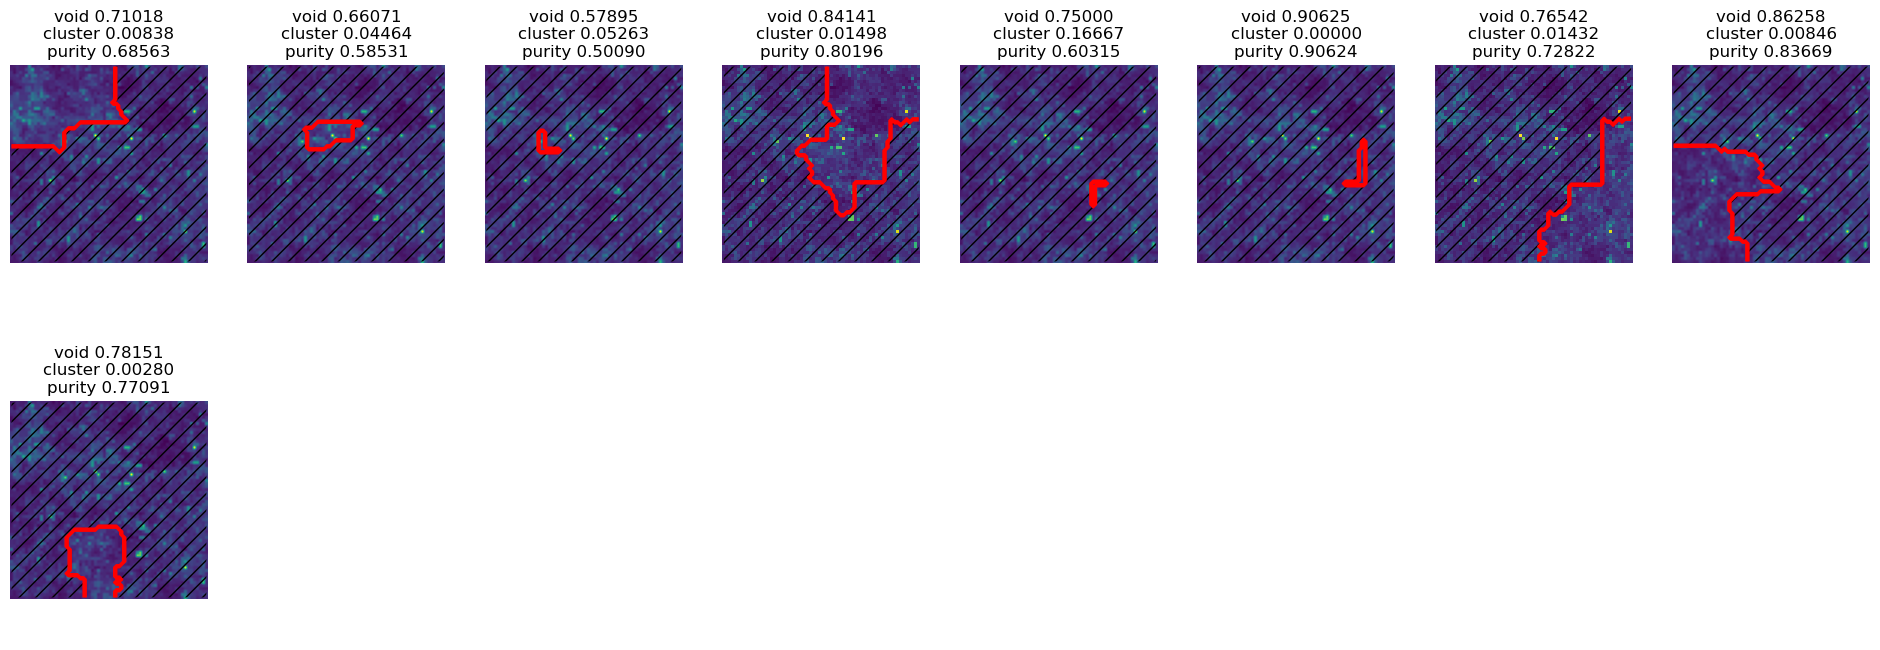

In [24]:
quickshift_baseline = QuickshiftGroups(
    kernel_size=5,
    max_dist=10,
    sigma=5).to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = quickshift_baseline(X)
show_example(groups, X)

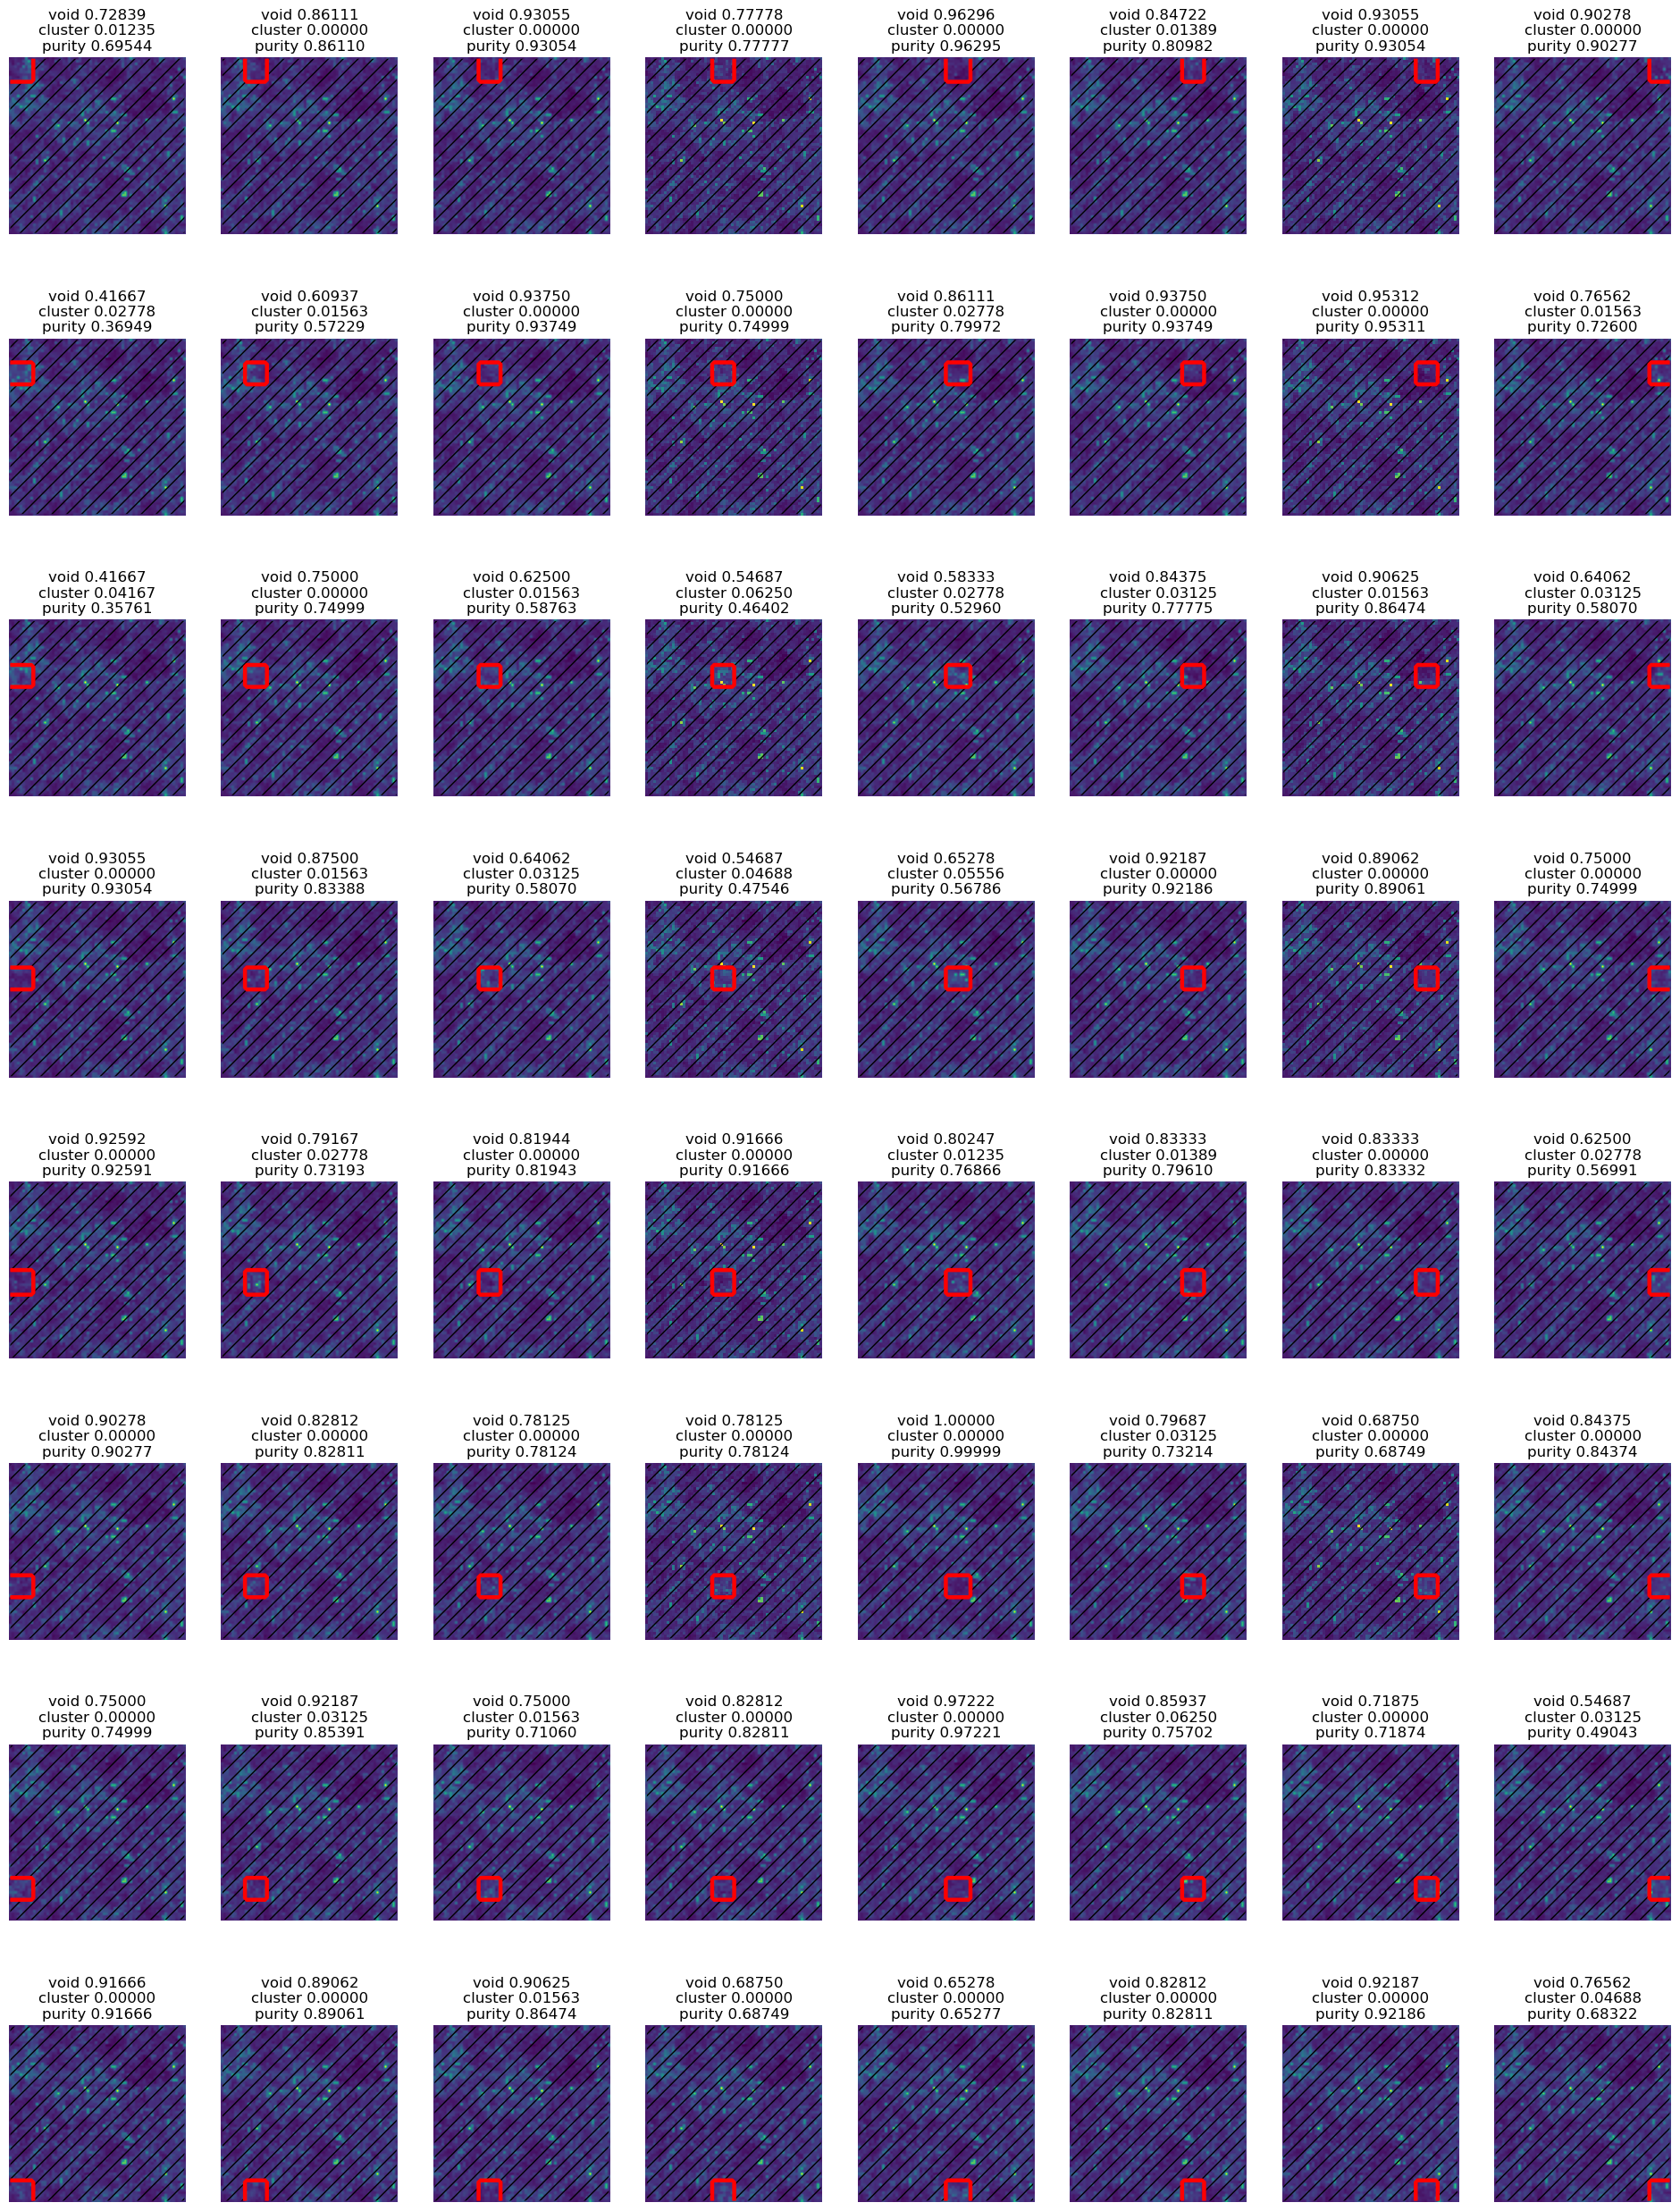

In [17]:
patch_baseline = PatchGroups(num_patches=(8, 8), mode='count').to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = patch_baseline(X)
show_example(groups, X)

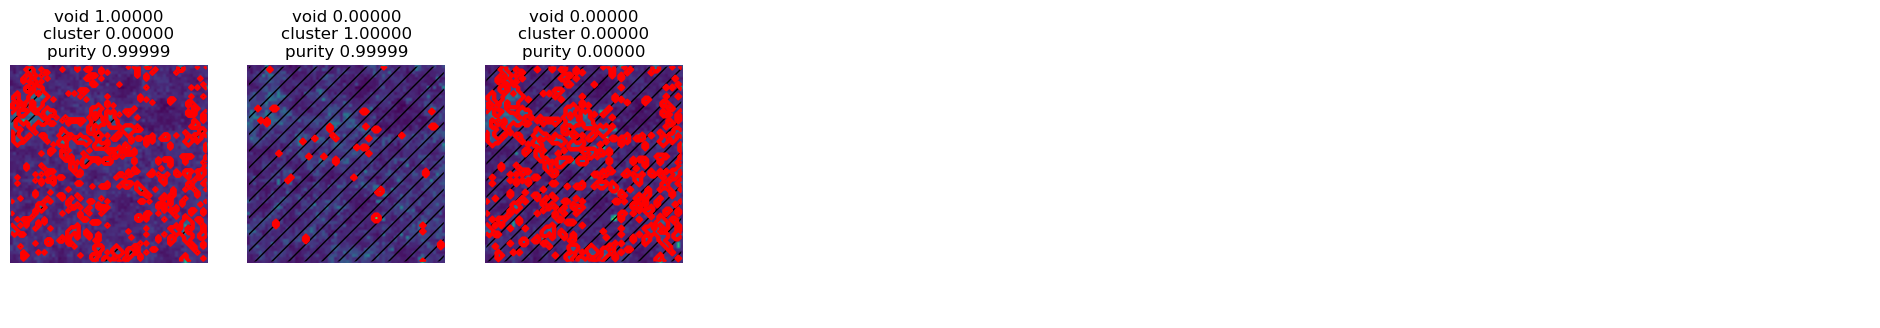

In [18]:
oracle_baseline = MassMapsOracle().to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = oracle_baseline(X)
show_example(groups, X)

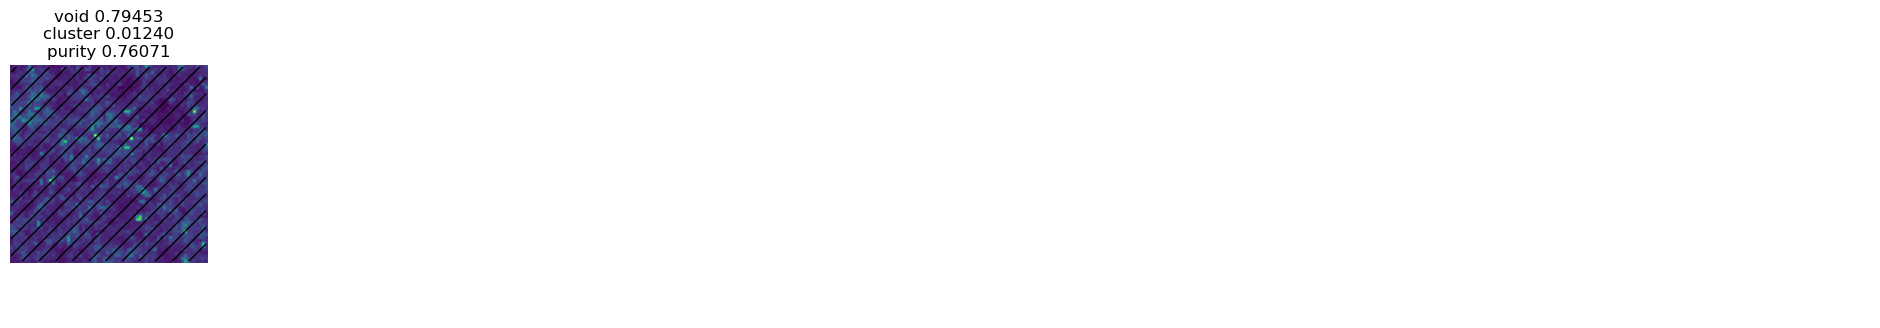

In [19]:
one_baseline = MassMapsOne().to(device)
X, y = train_dataset[0:2]['input'], train_dataset[0:2]['label']
groups = one_baseline(X)
show_example(groups, X)

# Compare baselines

In [2]:
from exlib.datasets.mass_maps import get_mass_maps_scores

mass_maps_fixscores = get_mass_maps_scores(subset=True)

  0%|          | 0/625 [00:00<?, ?it/s]

Omega_m loss 0.0042, sigma_8 loss 0.0103, avg loss 0.0072


In [6]:
import torch
methods = [
    'Watershed',
    'Quickshift',
    'Patch',
    'Oracle',
    'One'
]

for ni, name in enumerate(methods):
    metric = torch.tensor(mass_maps_fixscores[ni])
    mean_metric = metric.mean()
    print(f'{name}\t{mean_metric.item():.4f}')


Watershed	0.5632
Quickshift	0.5509
Patch	0.5623
Oracle	0.5938
One	0.5488


In [8]:
from exlib.features.vision.watershed import WatershedGroups
watershed_baseline = WatershedGroups(min_dist=10, compactness=0)
mass_maps_fixscores_watershed = get_mass_maps_scores([watershed_baseline], subset=True)

  0%|          | 0/625 [00:00<?, ?it/s]

Omega_m loss 0.0042, sigma_8 loss 0.0103, avg loss 0.0072


In [9]:
torch.mean(torch.tensor(mass_maps_fixscores_watershed))

tensor(0.5632)